Se importan librerías esenciales, establece una semilla para la reproducibilidad, carga conjuntos de datos de entrenamiento, validación y prueba desde archivos CSV y muestra sus dimensiones para verificar su estructura.

In [1]:
import pandas as pd
import pickle 
import numpy as np
from tqdm import tqdm_notebook as tqdm
from IPython.core.interactiveshell import InteractiveShell


np.random.seed(2)
x_train = np.loadtxt("/kaggle/input/features-extraction/x_train.csv", delimiter=",")
y_train = np.loadtxt("/kaggle/input/features-extraction/y_train.csv", delimiter=",")
x_cv = np.loadtxt("/kaggle/input/features-extraction/x_cv.csv", delimiter=",")
y_cv = np.loadtxt("/kaggle/input/features-extraction/y_cv.csv", delimiter=",")
x_test = np.loadtxt("/kaggle/input/features-extraction/x_test.csv", delimiter=",")
y_test = np.loadtxt("/kaggle/input/features-extraction/y_test.csv", delimiter=",")

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, 
                                                             y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))

Shape of x, y train/cv/test (2519, 225) (2519,) (1080, 225) (1080,) (900, 225) (900,)


Se calcula y muestra el porcentaje de cada clase en el conjunto de entrenamiento, lo que ayuda a entender la distribución y posible desbalance de clases.

In [2]:
_labels, _counts = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {}, class 1 = {}, class 2 = {}".format(_counts[0]/len(y_train) * 100, _counts[1]/len(y_train) * 100, _counts[2]/len(y_train) * 100))

percentage of class 0 = 87.97141722905914, class 1 = 6.073838824930529, class 2 = 5.954743946010321


Se define una función para remodelar los datos como imágenes y luego aplica esta transformación a los conjuntos de entrenamiento, validación y prueba. Además, agrega una dimensión adicional para los canales de color, asumiendo un formato de imagen en color (3 canales). Finalmente, muestra las dimensiones finales de los conjuntos de datos.

In [3]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

num_features = 225
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

final shape of x, y train/test (2519, 15, 15, 3) (2519,) (900, 15, 15, 3) (900,)


Se utiliza Matplotlib para visualizar imágenes aleatorias del conjunto de entrenamiento. Se configura un grid de 3x3 para mostrar 9 imágenes. Cada imagen se selecciona aleatoriamente, se muestra sin ejes y se etiqueta con su índice y clase correspondiente.

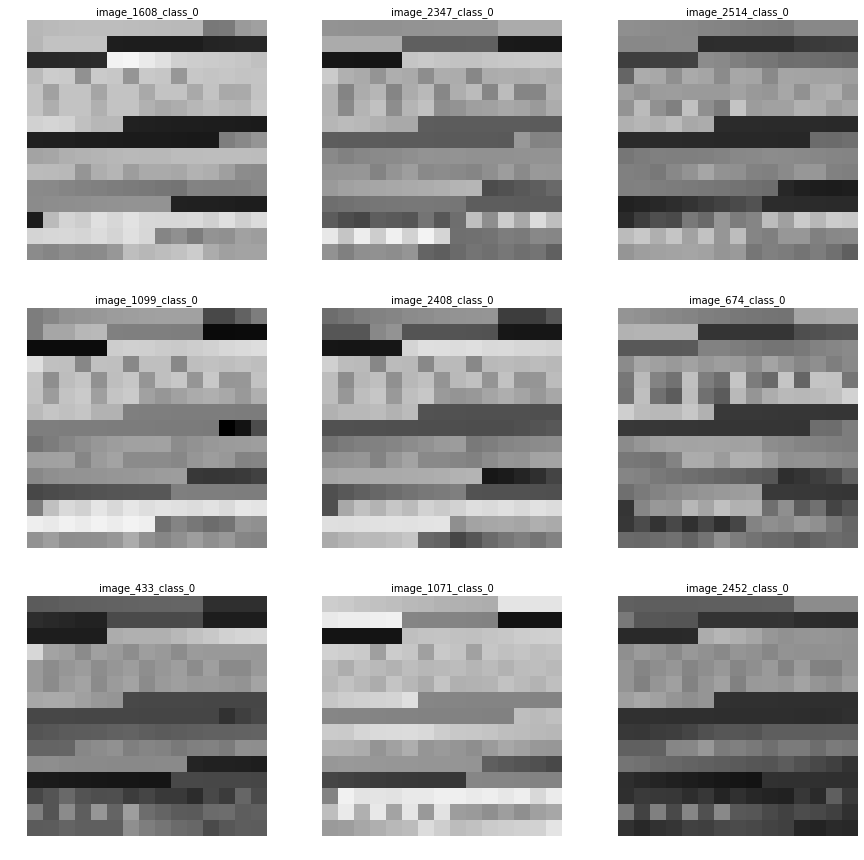

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()

Se define funciones para manejar datos desbalanceados y métricas personalizadas de F1 para TensorFlow: get_sample_weights calcula pesos de muestra basados en el desbalance de clases y f1_metric métrica de F1 score, integrándose en el entorno de Keras para su uso en modelos de TensorFlow.

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

def get_sample_weights(y):
    y = y.astype(int)  # compute_class_weight needs int labels
    class_weights = compute_class_weight('balanced', np.unique(y), y)
    
    print("real class weights are {}".format(class_weights), np.unique(y))
    print("value_counts", np.unique(y, return_counts=True))
    sample_weights = y.copy().astype(float)
    for i in np.unique(y):
        sample_weights[sample_weights == i] = class_weights[i]  
        

    return sample_weights


def f1_metric(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

get_custom_objects().update({"f1_metric": f1_metric})

Se calcula y muestra los pesos de las muestras para un subconjunto aleatorio del conjunto de entrenamiento, ayudando a verificar la asignación de pesos basada en el desbalance de clases.

In [6]:
sample_weights = get_sample_weights(y_train)
print("Test sample_weights")
rand_idx = np.random.randint(0, 1000, 30)
print(y_train[rand_idx])
print(sample_weights[rand_idx])

real class weights are [0.37891095 5.48801743 5.59777778] [0 1 2]
value_counts (array([0, 1, 2]), array([2216,  153,  150]))
Test sample_weights
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0.]
[0.37891095 0.37891095 0.37891095 0.37891095 0.37891095 0.37891095
 0.37891095 0.37891095 0.37891095 0.37891095 0.37891095 5.59777778
 0.37891095 0.37891095 5.59777778 0.37891095 0.37891095 0.37891095
 0.37891095 0.37891095 0.37891095 5.48801743 5.48801743 0.37891095
 0.37891095 0.37891095 0.37891095 0.37891095 0.37891095 0.37891095]


Se calcula y muestra el porcentaje de cada clase en el conjunto de entrenamiento para identificar la distribución y posible desbalance de clases.

In [7]:
_labels, _counts = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {}, class 1 = {}, class 2 = {}".format(_counts[0]/len(y_train) * 100, _counts[1]/len(y_train) * 100, _counts[2]/len(y_train) * 100))

percentage of class 0 = 87.97141722905914, class 1 = 6.073838824930529, class 2 = 5.954743946010321


Se aplica codificación one-hot a las etiquetas de los conjuntos de entrenamiento, validación y prueba, transformándolas en formatos compatibles con modelos de clasificación multiclase, y muestra las dimensiones resultantes para cada conjunto.

In [8]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder(sparse=False, categories='auto')  
y_train = one_hot_enc.fit_transform(y_train.reshape(-1, 1))
print("y_train",y_train.shape)
y_cv = one_hot_enc.transform(y_cv.reshape(-1, 1))
y_test = one_hot_enc.transform(y_test.reshape(-1, 1))
print("y_cv",y_cv.shape)
print("y_test",y_test.shape)

y_train (2519, 3)
y_cv (1080, 3)
y_test (900, 3)


Se importa diversas clases y funciones de TensorFlow y Keras necesarias para construir y entrenar una red neuronal convolucional (CNN). Incluye componentes para el modelo (como capas y regularizadores), callbacks para el entrenamiento, optimizadores, y métricas de evaluación como F1 y AUC.

In [9]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, RandomNormal
import tensorflow as tf
from functools import *
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import AUC



Se define una función make_model para construir un modelo de red neuronal convolucional. La función make_model crea un modelo secuencial con capas convolucionales, de pooling, dropout y densas, y devuelve este modelo. Finalmente, se instancia un modelo utilizando esta función.

In [10]:
def make_model(filter1=16, act1='relu', filter2=32, act2='relu', do1=.25, do2=.5, dense=32):
    input_shape = (15, 15, 3)
    cnn = Sequential([
        Conv2D(filters=filter1,
               kernel_size=3,
               padding='same',
               activation=act1,
               input_shape=input_shape,
               name='CONV1'),
        Conv2D(filters=filter2,        
               kernel_size=3,  
               padding='same',
               activation=act2,
               name='CONV2'),
        MaxPooling2D(pool_size=2, name='POOL2'),
        Dropout(do1, name='DROP1'),
        Flatten(name='FLAT1'),
        Dense(dense, activation='relu', name='FC1'),
        Dropout(do2, name='DROP2'),
        Dense(3, activation='softmax', name='FC2')
    ])
    
    return cnn

model = make_model()

Se configura callbacks para el entrenamiento del modelo:

EarlyStopping detiene el entrenamiento si no hay mejora en la pérdida de validación.
ReduceLROnPlateau reduce la tasa de aprendizaje si la pérdida de validación no mejora.
ModelCheckpoint guarda el mejor modelo basado en la métrica de validación F1.
También establece la ruta para guardar el mejor modelo.

In [11]:
import os

best_model_path = os.path.join('.', 'best_model_keras')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=100, min_delta=0.0001)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=20, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001)
mcp = ModelCheckpoint(best_model_path, monitor='val_f1_metric', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='max', period=1)  

Se compila el modelo configurando la función de pérdida como 'categorical_crossentropy' (adecuada para clasificación multiclase), el optimizador como 'adam' (un optimizador eficiente y popular), y las métricas para evaluar el modelo incluyen 'accuracy' y la métrica personalizada f1_metric.

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_metric])

Se entrena el modelo utilizando el conjunto de entrenamiento con sus respectivos pesos de muestra. Se configura para un máximo de 3000 épocas, con un tamaño de lote de 32, y utilizando los datos de validación cruzada para la evaluación. Incluye los callbacks configurados previamente (ModelCheckpoint, ReduceLROnPlateau, EarlyStopping) y mide el tiempo de entrenamiento con el comando %%time.

In [13]:
%%time
history = model.fit(x_train, y_train, epochs=3000, verbose=1,
                            batch_size=32, shuffle=True,
                            validation_data=(x_cv, y_cv),
                            callbacks=[mcp, rlp, es],
                            sample_weight=sample_weights)

Train on 2519 samples, validate on 1080 samples
Epoch 1/3000
2496/2519 [============================>.] - ETA: 0s - loss: 1.0258 - accuracy: 0.2680 - f1_metric: 0.0357
Epoch 00001: val_f1_metric improved from -inf to 0.09919, saving model to ./best_model_keras
2519/2519 [==============================] - 5s 2ms/sample - loss: 1.0270 - accuracy: 0.2684 - f1_metric: 0.0367 - val_loss: 0.9619 - val_accuracy: 0.2685 - val_f1_metric: 0.0992
Epoch 2/3000
2016/2519 [=======================>......] - ETA: 0s - loss: 0.7801 - accuracy: 0.2768 - f1_metric: 0.1451
Epoch 00002: val_f1_metric improved from 0.09919 to 0.11903, saving model to ./best_model_keras
2519/2519 [==============================] - 1s 437us/sample - loss: 0.7746 - accuracy: 0.2711 - f1_metric: 0.1394 - val_loss: 0.9526 - val_accuracy: 0.2509 - val_f1_metric: 0.1190
Epoch 3/3000
2080/2519 [=======================>......] - ETA: 0s - loss: 0.7029 - accuracy: 0.3567 - f1_metric: 0.2753
Epoch 00003: val_f1_metric improved from 0.

Se visualiza el rendimiento del modelo durante el entrenamiento. Muestra gráficas de la pérdida y la métrica F1 tanto para los conjuntos de entrenamiento como de validación a lo largo de las épocas. Esto ayuda a evaluar el aprendizaje y la generalización del modelo.

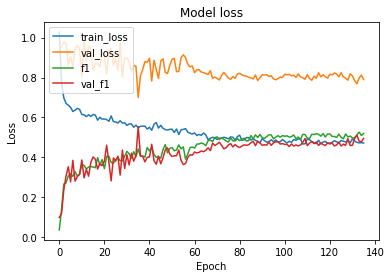

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
InteractiveShell.ast_node_interactivity = "last"

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['f1_metric'])
plt.plot(history.history['val_f1_metric'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss', 'f1', 'val_f1'], loc='upper left')
plt.show()

Se realiza la evaluación final del modelo sobre el conjunto de prueba:

1) Carga el mejor modelo guardado.   

2) Evalúa el modelo en el conjunto de prueba y obtiene las predicciones.

3) Calcula y muestra la matriz de confusión para visualizar el rendimiento del     modelo en clasificar cada clase.

4) Calcula las métricas de recall y precisión para cada clase.

5) Muestra dos gráficos de barras: uno para el recall y otro para la precisión     por clase, facilitando la comparación visual del rendimiento del modelo en       diferentes clases.

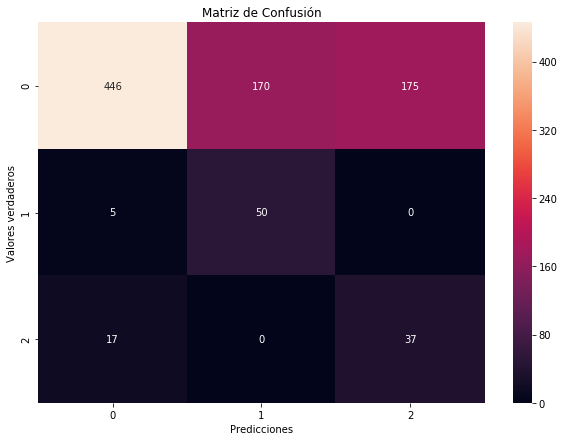

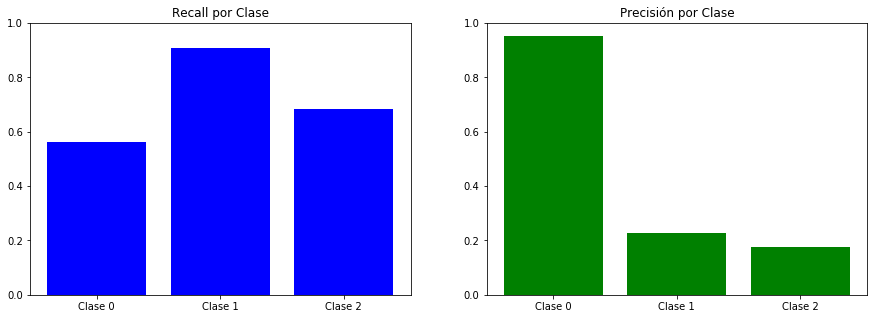

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import numpy as np
import seaborn as sns

# Carga tu modelo y evalúa los datos de prueba
model = load_model(best_model_path)
test_res = model.evaluate(x_test, y_test, verbose=0)

# Predicciones
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Recall y Precisión
recall = recall_score(y_true, y_pred_classes, average=None)
precision = precision_score(y_true, y_pred_classes, average=None)

# Gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión')
plt.show()

# Gráfico de barras para Recall y Precisión
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(['Clase 0', 'Clase 1', 'Clase 2'], recall, color='blue')
ax[0].set_title('Recall por Clase')
ax[0].set_ylim(0, 1)

ax[1].bar(['Clase 0', 'Clase 1', 'Clase 2'], precision, color='green')
ax[1].set_title('Precisión por Clase')
ax[1].set_ylim(0, 1)

plt.show()


In [16]:
recall

array([0.56384324, 0.90909091, 0.68518519])

In [17]:
precision

array([0.95299145, 0.22727273, 0.1745283 ])

Se imprime los resultados de la evaluación del modelo en el conjunto de prueba, mostrando la pérdida (loss), la precisión (accuracy) y la puntuación F1. Estos valores ayudan a comprender el rendimiento general del modelo en datos no vistos.

In [18]:
print(f"Loss: {test_res[0]}")
print(f"Accuracy: {test_res[1]}")
print(f"F1 score: {test_res[2]}")

Loss: 0.6517463986078899
Accuracy: 0.5922222137451172
F1 score: 0.5894395709037781


Se carga el mejor modelo guardado y lo vuelve a guardar con el nombre 'mi_modelo.h5'. Este paso es útil para renombrar y conservar el modelo entrenado para su uso o distribución futura.

In [19]:
model = load_model(best_model_path)
model.save('mi_modelo.h5')


Se implementa una estrategia para optimizar el umbral de clasificación:

1) Define una función apply_threshold para ajustar las predicciones basadas en un umbral específico. Si ninguna clase supera el umbral, asigna la clase 0; de lo contrario, selecciona la clase con la mayor probabilidad.

2) Itera sobre un rango de posibles umbrales para encontrar el que maximiza el F1 score.

3) Calcula el F1 score para cada umbral y actualiza el mejor umbral y el mejor F1 score.

4) Finalmente, imprime el mejor umbral encontrado y su correspondiente F1 score.









In [20]:
import numpy as np
from sklearn.metrics import f1_score

# Función para aplicar el umbral y ajustar las predicciones
def apply_threshold(predictions, threshold):
    adjusted_predictions = []
    for pred in predictions:
        if np.max(pred) < threshold:
            # Si ninguna clase supera el umbral, asignamos a la clase 0
            adjusted_pred = [1, 0, 0]
        else:
            # Si alguna clase supera el umbral, seleccionamos la de mayor probabilidad
            adjusted_pred = [0, 0, 0]  # Inicialmente, todas las clases se establecen en 0
            adjusted_pred[np.argmax(pred)] = 1  # Solo la clase con la mayor probabilidad se establece en 1
        adjusted_predictions.append(adjusted_pred)
    return np.array(adjusted_predictions)



# Define un rango de posibles umbrales
thresholds = np.linspace(0, 1, 100)  # 100 umbrales desde 0 a 1

# Inicializa el mejor umbral y el mejor F1 score
best_threshold = 0
best_f1 = 0

# Itera sobre los umbrales para encontrar el mejor
for threshold in thresholds:
    # Aplica el umbral
    y_pred_classes = apply_threshold(y_pred, threshold)
    y_pred_classes = np.argmax(y_pred_classes, axis=1)

    # Calcula el F1 score
    f1 = f1_score(y_true, y_pred_classes, average='macro')

    # Actualiza el mejor umbral si es necesario
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Imprime el mejor umbral y su F1 score
print("Mejor umbral:", best_threshold)
print("Mejor F1 score:", best_f1)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Mejor umbral: 0.686868686868687
Mejor F1 score: 0.5074228806801558


Se aplica el mejor umbral encontrado a las predicciones del modelo para ajustar la clasificación final. Utiliza la función apply_threshold para modificar las predicciones según el umbral y luego obtiene la clase final mediante np.argmax, que selecciona el índice de la clase con la probabilidad más alta en cada predicción ajustada.

In [21]:
y_pred_classes = apply_threshold(y_pred, best_threshold)
y_pred_classes = np.argmax(y_pred_classes, axis=1)

Se calcula y almacena la matriz de confusión, así como las métricas de recall y precisión, usando las predicciones ajustadas con el mejor umbral. Estos cálculos son fundamentales para evaluar el rendimiento detallado del modelo, especialmente después de ajustar las predicciones con el umbral óptimo.

In [22]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Recall y Precisión
recall = recall_score(y_true, y_pred_classes, average=None)
precision = precision_score(y_true, y_pred_classes, average=None)



Se calcula y muestra la puntuación F1 del modelo usando las predicciones ajustadas. Se utiliza el promedio 'macro', lo que significa que se calcula la puntuación F1 de forma independiente para cada clase y luego se toma el promedio de estas puntuaciones. Esto proporciona una medida de la efectividad del modelo en la clasificación equilibrada a través de todas las clases.

In [23]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred_classes, average='macro')
f1


0.5074228806801558

In [24]:
recall

array([0.7079646 , 0.83636364, 0.53703704])

In [25]:
precision

array([0.94276094, 0.25698324, 0.22834646])

Se visualiza dos aspectos clave del rendimiento del modelo:

Matriz de Confusión: Utiliza Seaborn para crear un mapa de calor de la matriz de confusión, mostrando la cantidad de predicciones correctas e incorrectas para cada clase.

Gráficos de Barras para Recall y Precisión: Muestra dos gráficos de barras para visualizar las métricas de recall y precisión para cada una de las tres clases, facilitando la comparación del rendimiento del modelo en términos de evitar falsos negativos y falsos positivos.

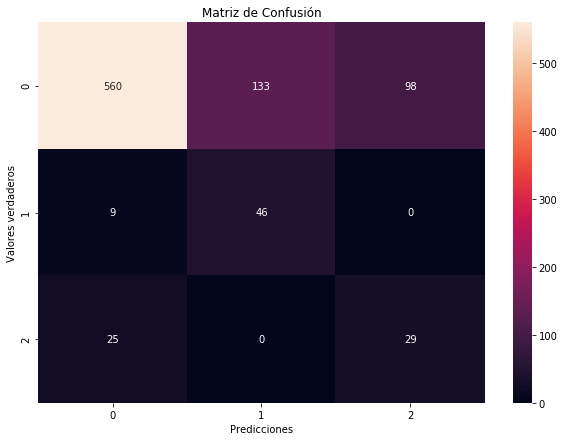

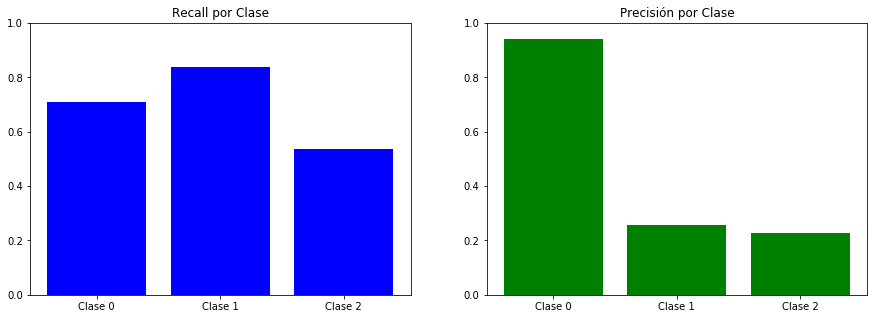

In [26]:
# Gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión')
plt.show()

# Gráfico de barras para Recall y Precisión
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(['Clase 0', 'Clase 1', 'Clase 2'], recall, color='blue')
ax[0].set_title('Recall por Clase')
ax[0].set_ylim(0, 1)

ax[1].bar(['Clase 0', 'Clase 1', 'Clase 2'], precision, color='green')
ax[1].set_title('Precisión por Clase')
ax[1].set_ylim(0, 1)

plt.show()
